### CSCA 5642 Introduction to Deep Learning Final Project

By - Arbind Kumar Singh

### Brief Description of the Problem and Data

In this final project, I aim to classify architectural heritage elements using Convolutional Neural Networks (CNNs). Specifically, I will develop a CNN that can categorize architectural features into various classes, including altar, apse, bell tower, column, dome (inner), dome (outer), flying buttress, gargoyle, stained glass, and vault. Additionally, I will experiment with different neural network architectures and perform hyperparameter tuning to understand the factors that significantly influence model performance.

This project is inspired by the article "Classification of Architectural Heritage Images Using Deep Learning Techniques" by Llamas et al. (2017). In the article, the authors evaluated several CNN models—considered state-of-the-art at the time—for classifying architectural heritage elements. Our project uses a dataset closely resembling the one employed by the authors, which they compiled and shared as part of their publication. The dataset, available from various sources and in multiple versions, was obtained for this project from the following link: Architectural Heritage Elements Image Dataset.
https://correo.cartif.es/home/joslla@cartif.es/Briefcase/Architectural_Heritage_Elements_image_Dataset  

While the primary goal of the original article was to assess the classification accuracy of state-of-the-art CNN models, our objective differs slightly. We aim to investigate the impact of various network architectures and hyperparameter tuning on model performance. In addition, we will compare our best-performing model with the least effective (AlexNet) and the most effective (Inception-ResNet-v2) models discussed in the original article.


References :
Llamas J, M. Lerones P, Medina R, Zalama E, Gómez-García-Bermejo J. Classification of Architectural Heritage Images Using Deep Learning Techniques. Applied Sciences. 2017; 7(10):992. https://doi.org/10.3390/app7100992

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from IPython.display import display, Image
import PIL
import time
import concurrent.futures
import pickle
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

### Exploratory Data Analysis

#### Inspect, Visualize and Clean the Data

In this section, I will do the following:

* Present a quantitative analysis of the data, detailing the number of images in each category.
* Conduct a visual inspection of a few sample images to ensure their quality and correctness.
* Confirm that all images share the same dimensions (128 x 128 x 3).
* Based on the findings, determine the necessary preprocessing steps to optimize the dataset for CNN modeling.

### Utility functions

In [7]:
def display_sample_images(directory, seed=42):
    """
    Displays one randomly selected image from each subdirectory in the given directory,
    with the subdirectory name displayed as the header of the image. Arranges images with 4 on the top two rows and 3 on the last row, with no visible axes.
    The function uses a random seed for reproducibility.

    Parameters:
    - directory (str): Path to the directory containing the subdirectories.
    - seed (int): Seed value for random number generator to ensure reproducibility.
    """
    random.seed(seed)  # Initialize the random number generator with the seed

    # List subdirectories
    directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    # Calculate the number of rows and columns
    num_images = len(directories)
    num_rows = 3
    num_cols = 4

    # Set up the figure for plotting
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))  # Set up a grid of 3x4 for the plots
    axs = axs.ravel()  # Flatten the axis array for easier iteration

    # Initially turn off all axes
    for ax in axs:
        ax.axis('off')
    
    # Process each subdirectory and display images
    for i, dir_name in enumerate(directories):
        if i < num_images:
            path = os.path.join(directory, dir_name)
            images = [img for img in os.listdir(path) if img.endswith(('.jpg', '.png'))]  # Adjust formats as necessary
            
            if images:
                selected_image = random.choice(images)  # Select a random image
                img_path = os.path.join(path, selected_image)
                img = PIL.Image.open(img_path)  # Open the image using PIL.Image
                
                # Display the image
                axs[i].imshow(img)
                axs[i].set_title(dir_name)  # Set the directory name as the title
                axs[i].axis('off')  # Keep axis off to only show the image

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [8]:
def check_image_shapes_against_target(folder_path, target_shape):
    """
    Checks the shapes of all images in the specified folder against a target shape and returns a list of boolean values.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_shape (tuple): A tuple containing the target (height, width, num_channels).

    Returns:
    - List of boolean: Each element is True if the corresponding image matches the target shape, False otherwise.
    """
    # Get all image files from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    match_results = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)  # Construct the full path to the image
        
        # Open the image and get its properties
        with PIL.Image.open(img_path) as img:
            width, height = img.size
            num_channels = len(img.getbands())
            current_shape = (height, width, num_channels)
            
            # Compare current image shape with the target shape
            match_results.append(current_shape == target_shape)

    return match_results



def find_non_conforming_images(folder_path, target_shape):
    """
    Identifies images in the specified folder that do not match a target shape and returns their filenames.

    Parameters:
    - folder_path (str): Path to the folder containing the images.
    - target_shape (tuple): A tuple containing the target (height, width, num_channels).

    Returns:
    - List of str: Filenames of images that do not match the target shape.
    """
    # Get all image files from the folder
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    non_conforming_files = []
    for image_file in image_files:
        img_path = os.path.join(folder_path, image_file)  # Construct the full path to the image
        
        # Open the image and get its properties
        with PIL.Image.open(img_path) as img:
            width, height = img.size
            num_channels = len(img.getbands())
            current_shape = (height, width, num_channels)
            
            # Add the file to the list if it does not match the target shape
            if current_shape != target_shape:
                non_conforming_files.append(image_file)

    return non_conforming_files

### Dataset Investigation

In [ ]:
directories = [directory for directory in os.listdir('Architectural_Heritage_Elements_Dataset_128') if directory != '.DS_Store']
number_of_files = list()

for directory in directories:
    number_of_files.append(len(os.listdir('Architectural_Heritage_Elements_Dataset_128/' + directory)))

data = zip(directories, number_of_files)
df_files = pd.DataFrame(data, columns=['Directory', 'Number of Files'])
df_files

,Directory,Number of Files
0,bell_tower,1059
1,dome(outer),1177
2,gargoyle,1571
3,portal,308
4,flying_buttress,407
5,dome(inner),616
6,stained_glass,1033
7,column,1919
8,apse,514
9,vault,1110


In [10]:
# Total number of files
num_files_tot = df_files['Number of Files'].sum()
print(f"The total number of files are: {num_files_tot}")

The total number of files are: 10543


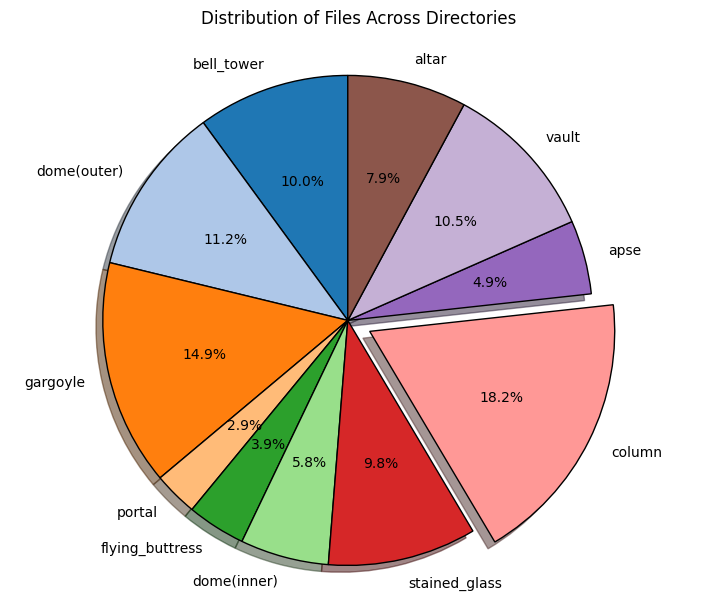

In [11]:
# Improved color palette from the tab20 colormap, ensuring good visibility
colors = plt.cm.tab20.colors  # This uses a tabulated colormap with 20 unique colors

# Create a pie chart with additional visual enhancements
plt.figure(figsize=(9, 7))  # Adjust the figure size as needed to make it more prominent
# Explode the largest slice for emphasis
explode = [0.1 if i == df_files['Number of Files'].idxmax() else 0 for i in range(len(df_files['Directory']))]
# Add shadow for a 3D effect
plt.pie(df_files['Number of Files'], labels=df_files['Directory'], autopct='%1.1f%%', startangle=90,
        colors=colors[:len(df_files['Directory'])], explode=explode, shadow=True, wedgeprops={'edgecolor': 'black'})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Optional: add a title to the chart
plt.title('Distribution of Files Across Directories', pad=20)  # Added padding for better layout

# Show the plot
plt.show()


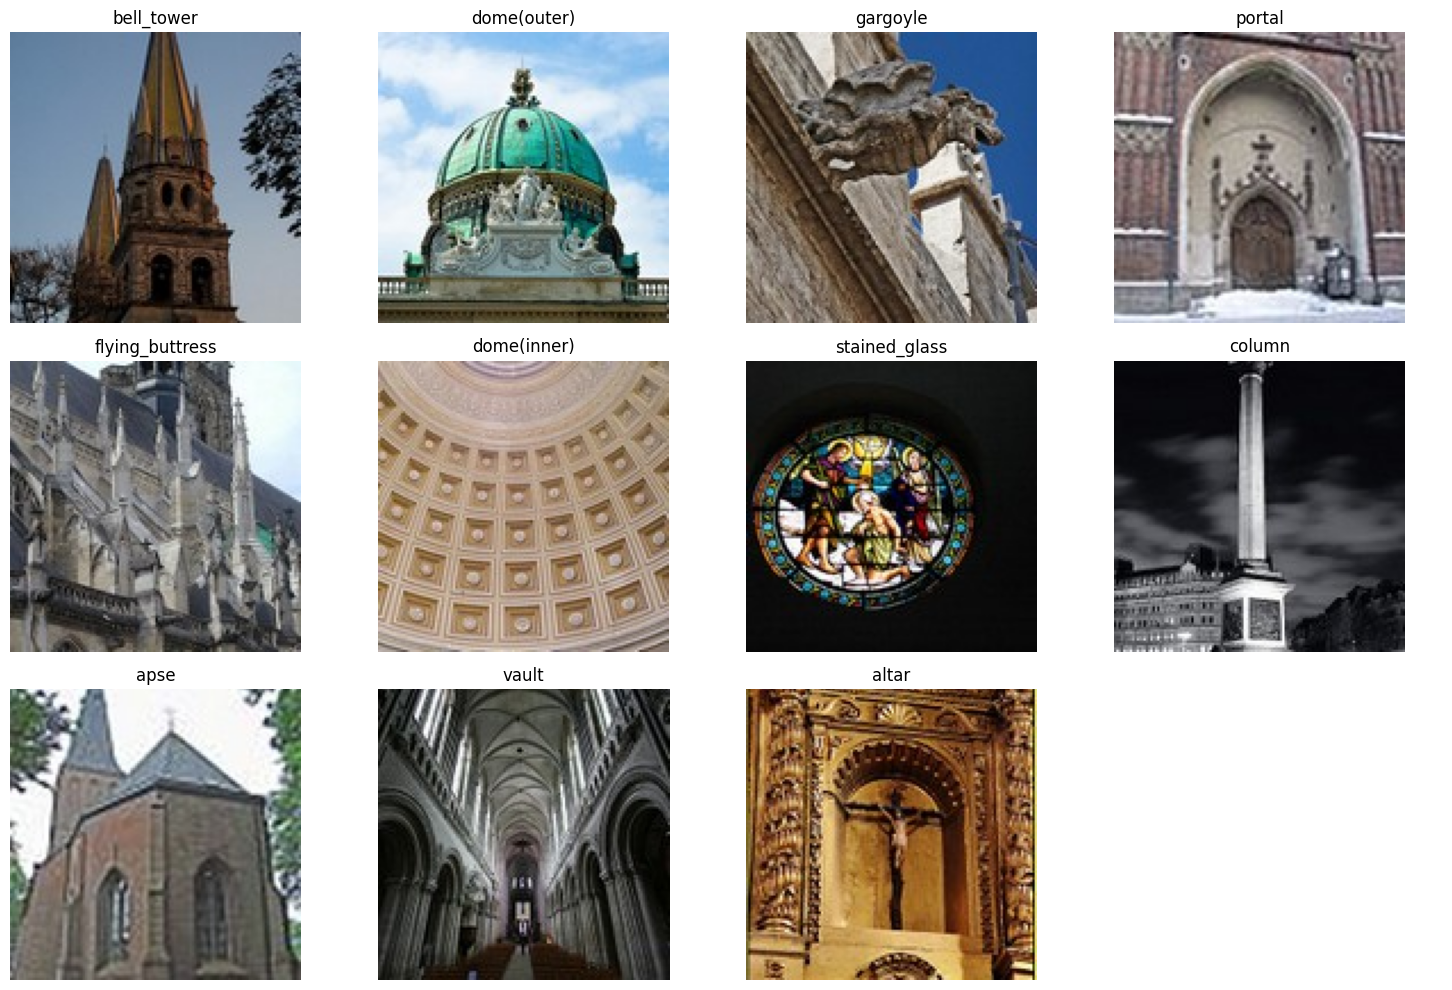

In [ ]:
display_sample_images('Architectural_Heritage_Elements_Dataset_128')

In [13]:
for directory in directories:
    print(f"{directory: <16} ... All images are shape (128, 128, 3) ... {all(check_image_shapes_against_target(f'Architectural_Heritage_Elements_Dataset_128/{directory}', (128, 128, 3)))}")

bell_tower       ... All images are shape (128, 128, 3) ... True
dome(outer)      ... All images are shape (128, 128, 3) ... True
gargoyle         ... All images are shape (128, 128, 3) ... True
portal           ... All images are shape (128, 128, 3) ... True
flying_buttress  ... All images are shape (128, 128, 3) ... False
dome(inner)      ... All images are shape (128, 128, 3) ... True
stained_glass    ... All images are shape (128, 128, 3) ... True
column           ... All images are shape (128, 128, 3) ... True
apse             ... All images are shape (128, 128, 3) ... True
vault            ... All images are shape (128, 128, 3) ... True
altar            ... All images are shape (128, 128, 3) ... True


In [14]:
# Find non-conforming image
non_conforming_images = find_non_conforming_images('Architectural_Heritage_Elements_Dataset_128/flying_buttress', (128, 128, 3))
print("Non-conforming image files:", non_conforming_images)

Non-conforming image files: ['Le_Mont_Saint-Michel_en_1948_(9).jpg']


### Dataset Invetigation Outcome

Based on our investigations, I can conclude that:

* The dataset consists of 11 categories of architectural heritage elements. 
* This is one more category of heritage elements than in the original study. The extra category is portal. Since portal makes up such a small amount of the total dataset (2.9%), we will drop this category when we develop our model.
* There is one image in the flying buttress category that does not conform to the 128 x 128 x 3 format - Le_Mont_Saint-Michel_en_1948_(9).jpg. It will not be used in our model building efforts.
* In total, there are a large number of images (10543), which makes it easier to train the CNN. However, there are also a considerable number of possible categories (10), which makes it harder to create a model with a high level of accuracy. 

## Model Architecture

In this section, I will try out four different CNN architectures:

* **Basic Architecture** with two combined sets of one convolution layer followed by one max pooling layers.
* **Deep Architecture** with three sets of one convolution layer followed by one max pooling layers.
* **Double Convolution Layer Architecture** with two sets of two convolution layers followed by one max pooling layer.
* **Double Deep Architecture** which has three sets of double convolution layers (combination of the two previous architectures).

The principal idea here is to see if I can improve the accuracy of our prediction by adopting specific architectural principles. Adding more layers to a CCN-model should enhance its capacity to learn more complex features from the data. We will test this theory by adopting the Deep Architecture. And adding double convolution layers should allow the network to perform more complex feature extraction before pooling and enable it to better recognize and combine detailed patterns within the input data. We will test that theory by adopting the Double Convolution Layer Architecture. In both cases, I will compare these models with a model that applies a simpler and less sophisticated architecture, which I will refer to as the Basic Architecture. Finally, I will test a Double Deep model that combines both extra layers and double convolution layers. See illustration below.

The models also share some common features. Each of these models will make use of a **dropout layer** before the output layer to add some regularization to the models. The models also apply the principle of **increasing number of filters** in the deeper layers of a convolutional neural network to be able to capture more complex and abstract features in the input data. For more on this topic see for instance Albelwi and Mahmood, 2017.

Since there is a limited amount of data for each category, I will only split the data into a training and validation set. Ideally, I would have compared the models using a separate test dataset, but that would have taken too many images out of the training set and adversely affected the model performance. Therefore, I compare the models using their validation scores.

In this section, I will exclusively focus on the architecture of the CNN and will not try to improve them using different optimizers or regularization techniques. We will do that in the next section after I have settled on a preferred architecture. 

References:
Albelwi S, Mahmood A. A Framework for Designing the Architectures of Deep Convolutional Neural Networks. Entropy. 2017; 19(6):242. https://doi.org/10.3390/e19060242.

### Utility functions

In [15]:
def create_dataset(directory, output_directory, exclude_folder=None, exclude_image=None, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Creates a dataset divided into training, validation, and test sets from a directory of images,
    allowing for exclusion of specific folders and images. Outputs the dataset into a specified root folder.
    Can optionally exclude the test set by setting test_size to 0.

    Parameters:
    - directory (str): The root directory containing subdirectories for each class.
    - output_directory (str): The root directory where train, val, and (optionally) test directories will be created.
    - exclude_folder (str): Name of the folder to exclude from the dataset.
    - exclude_image (str): Filename of an image to exclude from the dataset.
    - train_size (float): Proportion of the dataset to include in the train split.
    - val_size (float): Proportion of the dataset to include in the validation split.
    - test_size (float): Proportion of the dataset to include in the test split.
    """
    # Setup directories for train and validation sets within the output directory
    train_dir = os.path.join(output_directory, 'train')
    val_dir = os.path.join(output_directory, 'val')
    
    # Create directories if they don't exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Optionally setup the directory for test set
    test_dir = None
    if test_size > 0:
        test_dir = os.path.join(output_directory, 'test')
        os.makedirs(test_dir, exist_ok=True)

    # Process each subdirectory in the main directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        if os.path.isdir(folder_path) and folder != exclude_folder:
            class_train_dir = os.path.join(train_dir, folder)
            class_val_dir = os.path.join(val_dir, folder)
            class_test_dir = os.path.join(test_dir, folder) if test_dir else None

            # Create class directories in train, val, and optionally test directories
            os.makedirs(class_train_dir, exist_ok=True)
            os.makedirs(class_val_dir, exist_ok=True)
            if class_test_dir:
                os.makedirs(class_test_dir, exist_ok=True)

            # Get all image files except the excluded one
            images = [img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')) and img != exclude_image]

            # Check if there are any images to split
            if images:
                if test_size > 0:
                    # Split the images into train, val, and test
                    train_images, test_val_images = train_test_split(images, train_size=train_size + val_size, random_state=42)
                    val_images, test_images = train_test_split(test_val_images, test_size=test_size / (test_size + val_size), random_state=42)
                else:
                    # Split the images into just train and val
                    train_images, val_images = train_test_split(images, train_size=train_size / (train_size + val_size), random_state=42)

                # Copy images to their respective directories
                for img in train_images:
                    shutil.copy(os.path.join(folder_path, img), class_train_dir)
                for img in val_images:
                    shutil.copy(os.path.join(folder_path, img), class_val_dir)
                if test_size > 0 and test_images:
                    for img in test_images:
                        shutil.copy(os.path.join(folder_path, img), class_test_dir)
            else:
                print(f"No valid images found in {folder_path} to split.")

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_train_generator(train_dir, target_size=(96, 96), batch_size=32):
    """
    Creates a training data generator.
    
    Parameters:
    - train_dir (str): Path to the training directory.
    - target_size (tuple): Tuple of integers (height, width), default to (96, 96).
    - batch_size (int): Size of the batches of data (default: 32).

    Returns:
    - train_generator: An instance of DirectoryIterator yielding tuples of (x, y)
      where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels)
      and y is a numpy array of corresponding labels.
    """
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if you have more than two classes
    )
    return train_generator


def create_val_generator(val_dir, target_size=(96, 96), batch_size=32):
    """
    Creates a validation data generator.
    
    Parameters:
    - val_dir (str): Path to the validation directory.
    - target_size (tuple): Tuple of integers (height, width), default to (96, 96).
    - batch_size (int): Size of the batches of data (default: 32).

    Returns:
    - val_generator: An instance of DirectoryIterator yielding tuples of (x, y)
      where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels)
      and y is a numpy array of corresponding labels.
    """
    val_datagen = ImageDataGenerator(rescale=1./255)
    val_generator = val_datagen.flow_from_directory(
        directory=val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if you have more than two classes
    )
    return val_generator


def create_early_stopper(monitor='val_accuracy', patience=5):
    early_stopper = EarlyStopping(
        monitor=monitor,
        patience=patience,
        verbose=1,
        restore_best_weights=True
    )
    return early_stopper
    

In [17]:
def plot_training_history(history):
    # Get number of epochs
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training & validation accuracy values
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)  # Set x-ticks to be the epochs
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    

In [18]:
def get_best_epoch_stats(model_names, histories):
    accuracies = []
    losses = []
    
    for model_name, history in zip(model_names, histories):
        # Get the index of the epoch with the highest validation accuracy
        best_epoch_index = np.argmax(history.history['val_accuracy'])
        
        # Retrieve the accuracy and loss for the best epoch
        best_epoch_accuracy = history.history['val_accuracy'][best_epoch_index]
        best_epoch_loss = history.history['val_loss'][best_epoch_index]
        
        # Append the results to the respective lists
        accuracies.append(best_epoch_accuracy)
        losses.append(best_epoch_loss)
    
    return model_names, accuracies, losses
    

In [19]:
def plot_model_metrics(architectures, accuracies, losses):
    # Define colors
    accuracy_color = '#5BC0BE'
    loss_color = '#4C698D'

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot accuracy
    axs[0].bar(architectures, accuracies, color=accuracy_color)
    axs[0].set_title('Model Accuracy', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_ylim([0, 1])

    # Adding the text labels on the bars
    for i in range(len(accuracies)):
        axs[0].text(i, accuracies[i] + 0.02, f'{accuracies[i]:.2f}', ha='center', va='bottom', color='black')

    # Plot loss
    axs[1].bar(architectures, losses, color=loss_color)
    axs[1].set_title('Model Loss', fontsize=14)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_ylim([0, max(losses)+0.1])

    # Adding the text labels on the bars
    for i in range(len(losses)):
        axs[1].text(i, losses[i] + 0.02, f'{losses[i]:.2f}', ha='center', va='bottom', color='white')  # white text for better visibility on dark color

    # Layout adjustments
    plt.tight_layout()

    # Display the plot
    plt.show()


### Creating dataset (Training and test dataset)

In [20]:
# Creating dataset:
create_dataset(
    directory='Architectural_Heritage_Elements_Dataset_128',
    output_directory='data',
    exclude_folder='portal',  # optional
    exclude_image='Le_Mont_Saint-Michel_en_1948_(9).jpg',  # optional
    train_size=0.8,
    val_size=0.2,
    test_size=0.0
)

### Basic Architecture
with two combined sets of one convolution layer followed by one max pooling layers

In [21]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# Adjusted CNN Model Structure for 10-class classification
model_basic = Sequential([
    Input(shape=(128, 128, 3)),  # Input layer for 128x128x3 images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes
])

model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model with the adjusted setup
history_basic = model_basic.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 295ms/step - accuracy: 0.2480 - loss: 2.1054 - val_accuracy: 0.4598 - val_loss: 1.5641
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 72s 280ms/step - accuracy: 0.3992 - loss: 1.6265 - val_accuracy: 0.5300 - val_loss: 1.3523
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.4731 - loss: 1.4170 - val_accuracy: 0.5744 - val_loss: 1.2841
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 278ms/step - accuracy: 0.5108 - loss: 1.3296 - val_accuracy: 0.6173 - val_loss: 1.1585
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 71s 277ms/step - accuracy: 0.5792 - loss: 1.1467 - val_accuracy: 0.6324 - val_loss: 1.1067
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 70s 274ms/step - accuracy: 0.6075 - loss: 1.0596 - val_accuracy: 0.6446 - val_loss: 1.0436
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 69s 271ms/step - accuracy: 0.6600 - loss: 0.9339 - val_accuracy: 0.6767 - val_loss: 0.95

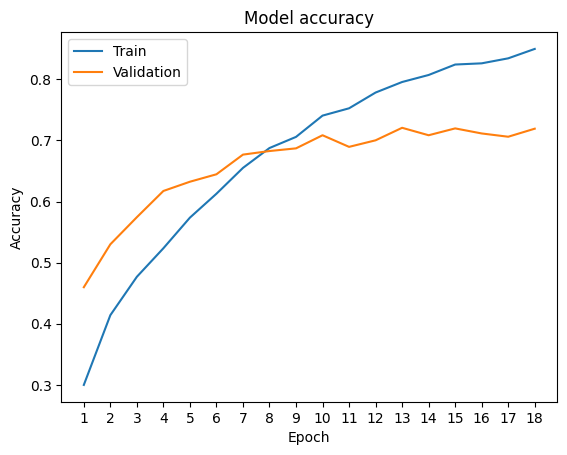

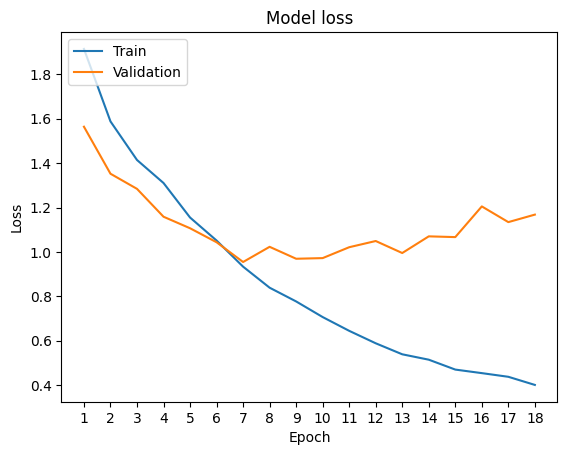

In [22]:
plot_training_history(history_basic)

### Deep Architecture
with three sets of one convolution layer followed by one max pooling layers.

In [23]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# CNN Model Structure with Input layer and additional Conv and MaxPooling layers
model_deep = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),  # Additional Conv layer
    MaxPooling2D(2, 2),                      # Additional MaxPooling layer
    Flatten(),
    Dense(128, activation='relu'),  # Increased neurons in the Dense layer
    Dropout(0.5),
    Dense(10, activation='softmax')  # Adjusted for 10 classes with softmax
])

model_deep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_deep = model_deep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 299ms/step - accuracy: 0.3195 - loss: 1.8497 - val_accuracy: 0.6197 - val_loss: 1.1495
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 79s 307ms/step - accuracy: 0.5736 - loss: 1.2422 - val_accuracy: 0.6509 - val_loss: 0.9893
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 294ms/step - accuracy: 0.6473 - loss: 1.0179 - val_accuracy: 0.6958 - val_loss: 0.9001
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 295ms/step - accuracy: 0.6919 - loss: 0.8785 - val_accuracy: 0.6909 - val_loss: 0.9012
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 306ms/step - accuracy: 0.7275 - loss: 0.7771 - val_accuracy: 0.7304 - val_loss: 0.8010
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 75s 294ms/step - accuracy: 0.7873 - loss: 0.6176 - val_accuracy: 0.7494 - val_loss: 0.8200
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 76s 296ms/step - accuracy: 0.8156 - loss: 0.5347 - val_accuracy: 0.7255 - val_loss: 0.85

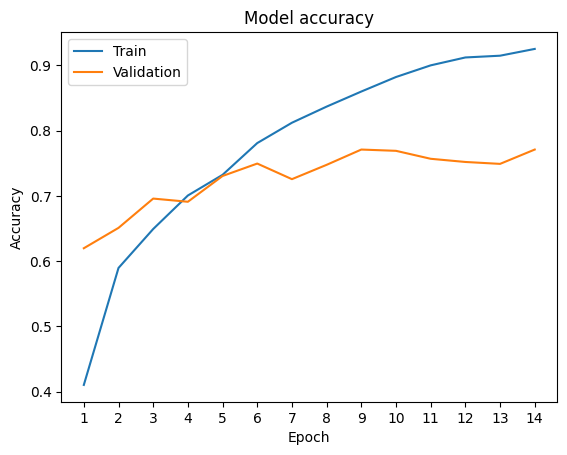

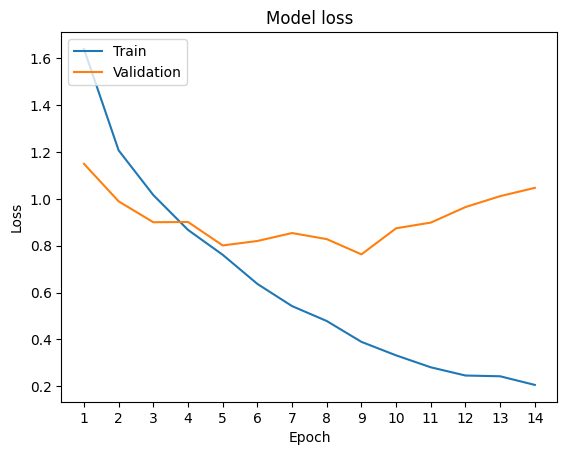

In [24]:
plot_training_history(history_deep)

### Double Convolution Layer Architecture
with two sets of two convolution layers followed by one max pooling layer.

In [25]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)


# CNN Model Structure with double convolution layers
model_doubleConv = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # 'same' padding to maintain dimension
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for 10 classes with softmax
])

model_doubleConv.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleConv= model_doubleConv.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 179s 691ms/step - accuracy: 0.2834 - loss: 2.0407 - val_accuracy: 0.5329 - val_loss: 1.3620
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 174s 681ms/step - accuracy: 0.5426 - loss: 1.3193 - val_accuracy: 0.6460 - val_loss: 1.0401
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 178s 697ms/step - accuracy: 0.6415 - loss: 1.0202 - val_accuracy: 0.6821 - val_loss: 0.9096
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 174s 680ms/step - accuracy: 0.7039 - loss: 0.8581 - val_accuracy: 0.7079 - val_loss: 0.8655
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 175s 685ms/step - accuracy: 0.7586 - loss: 0.6874 - val_accuracy: 0.6958 - val_loss: 0.9246
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 175s 683ms/step - accuracy: 0.7998 - loss: 0.5632 - val_accuracy: 0.7235 - val_loss: 0.8596
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 175s 683ms/step - accuracy: 0.8497 - loss: 0.4141 - val_accuracy: 0.7235 - val_los

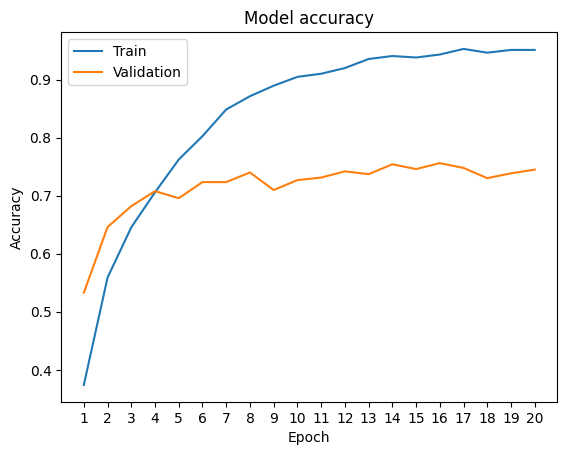

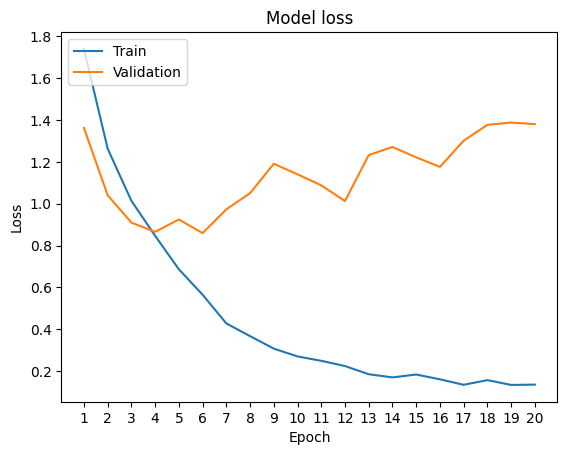

In [26]:
plot_training_history(history_doubleConv)

### Double Deep Architecture
which has three sets of double convolution layers (combination of the two previous architectures).

In [27]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_doubleDeep.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleDeep = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 231s 893ms/step - accuracy: 0.2811 - loss: 1.9931 - val_accuracy: 0.4963 - val_loss: 1.4297
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 228s 890ms/step - accuracy: 0.5062 - loss: 1.4100 - val_accuracy: 0.6231 - val_loss: 1.1497
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 228s 889ms/step - accuracy: 0.6132 - loss: 1.1207 - val_accuracy: 0.6660 - val_loss: 0.9657
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 225s 880ms/step - accuracy: 0.6741 - loss: 0.9707 - val_accuracy: 0.7182 - val_loss: 0.8515
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 884ms/step - accuracy: 0.7366 - loss: 0.7592 - val_accuracy: 0.7528 - val_loss: 0.7702
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 883ms/step - accuracy: 0.7811 - loss: 0.6376 - val_accuracy: 0.7538 - val_loss: 0.7403
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 229s 896ms/step - accuracy: 0.8172 - loss: 0.5410 - val_accuracy: 0.7665 - val_los

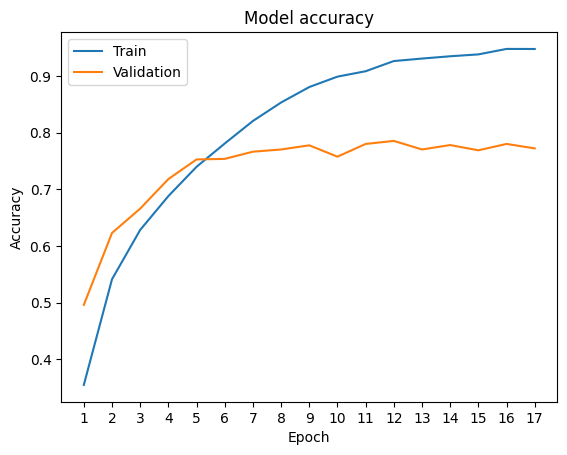

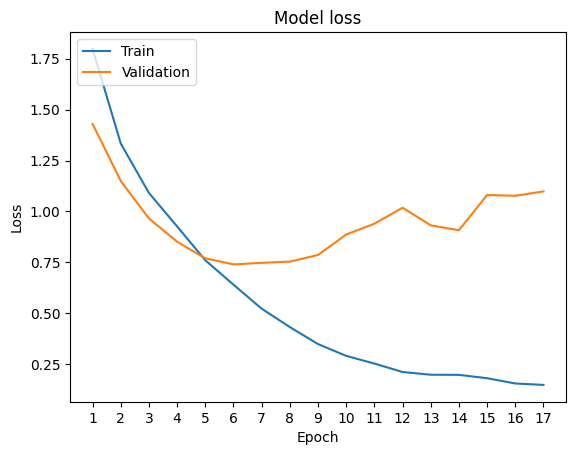

In [28]:
plot_training_history(history_doubleDeep)

###  Utilities

In [ ]:
# Plot models
plot_model(model_basic, to_file='images/model_basic.png', show_shapes=True, show_layer_names=True)
plot_model(model_deep, to_file='images/model_deep.png', show_shapes=True, show_layer_names=True)
plot_model(model_doubleConv, to_file='images/model_doubleConv.png', show_shapes=True, show_layer_names=True)
plot_model(model_doubleDeep, to_file='images/model_doubleDeep.png', show_shapes=True, show_layer_names=True)
print("All images finished")

In [ ]:
# Save models
model_basic.save('models/model_basic.keras')
model_deep.save('models/model_deep.keras')
model_doubleConv.save('models/model_doubleConv.keras')
model_doubleDeep.save('models/model_doubleDeep.keras')

# Save history
with open('history/model_basic.pkl', 'wb') as file:
    pickle.dump(history_basic.history, file)

with open('history/model_deep.pkl', 'wb') as file:
    pickle.dump(history_deep.history, file)

with open('history/model_doubleConv.pkl', 'wb') as file:
    pickle.dump(history_doubleConv.history, file)

with open('history/model_doubleDeep.pkl', 'wb') as file:
    pickle.dump(history_doubleDeep.history, file)

In [33]:
# Load models
#model_basic = load_model('models/model_basic.keras')
#model_deep = load_model('models/model_deep.keras')
#model_doubleConv = load_model('models/model_doubleConv.keras')
#model_doubleDeep = load_model('models/model_doubleDeep.keras')

### Conclusion

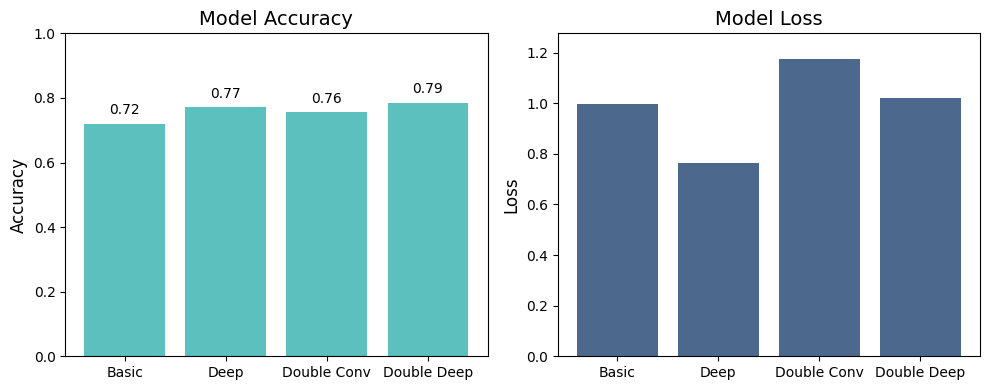

In [29]:
best = get_best_epoch_stats( ('Basic','Deep', 'Double Conv', 'Double Deep'), (history_basic, history_deep, history_doubleConv, history_doubleDeep)  )
plot_model_metrics(*best)

As We can see from the figures above, the Double Deep model outperforms the other three architectures (at least when we look at accuracy). We will therefore continue using the Double Deep architecture for the rest of this project. 
An even deeper model architecture could perhaps have resulted in even better results. 

I will explore if the Deep model can be further improved by changing optimizer and introducing regularization.

### Results and Analysis

In this part of the assignment, I will try out different techniques to improve the training or performance. There exists many methods one can use to improve the performance of a CNN - such as trying out different optimizers, adding L2 regularization to the neurons in the network, altering the number of neurons dropped by the dropout layers, carrying out batch normalization and trying out different learning rates - to mention a few.

I will focus on testing the impact of **optimizers** and **L2 regularization**. 

More specifically, I will test whether another optimizer - RMSprop - can produce better results, and I will see if L2 regularization factor of 0.001 and 0.0001 can increase the accuracy. In all cases, I will use our top performing model, which is the Double Deep CNN model.

### Optimizers

In [ ]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_doubleDeep_RMSprop = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_doubleDeep_RMSprop.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_doubleDeep_RMSprop = model_doubleDeep.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 229s 892ms/step - accuracy: 0.9349 - loss: 0.1831 - val_accuracy: 0.7879 - val_loss: 0.8904
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9441 - loss: 0.1699 - val_accuracy: 0.7845 - val_loss: 1.0129
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 231s 901ms/step - accuracy: 0.9455 - loss: 0.1636 - val_accuracy: 0.7572 - val_loss: 1.1109
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 232s 905ms/step - accuracy: 0.9432 - loss: 0.1605 - val_accuracy: 0.7713 - val_loss: 1.1591
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 232s 905ms/step - accuracy: 0.9490 - loss: 0.1388 - val_accuracy: 0.7562 - val_loss: 1.2156
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 221s 864ms/step - accuracy: 0.9381 - loss: 0.1803 - val_accuracy: 0.7811 - val_loss: 1.0904
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


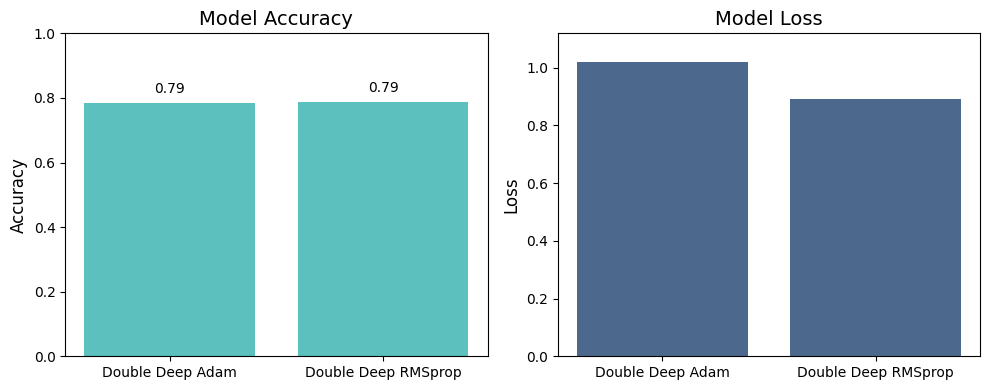

In [ ]:
best = get_best_epoch_stats( ('Double Deep Adam', 'Double Deep RMSprop'), (history_doubleDeep, history_doubleDeep_RMSprop)  )
plot_model_metrics(*best)

### L2 Regularization
L2 regularization factor of 0.001

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_l2_001 = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_l2_001.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_l2_001 = model_l2_001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)


Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 257s 991ms/step - accuracy: 0.2117 - loss: 2.4064 - val_accuracy: 0.3501 - val_loss: 1.8500
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 245s 955ms/step - accuracy: 0.3288 - loss: 1.8857 - val_accuracy: 0.4773 - val_loss: 1.5643
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 231s 900ms/step - accuracy: 0.4599 - loss: 1.6272 - val_accuracy: 0.5529 - val_loss: 1.4011
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 881ms/step - accuracy: 0.5521 - loss: 1.4258 - val_accuracy: 0.6021 - val_loss: 1.3182
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 229s 896ms/step - accuracy: 0.5766 - loss: 1.3504 - val_accuracy: 0.6163 - val_loss: 1.2452
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 228s 891ms/step - accuracy: 0.6274 - loss: 1.2281 - val_accuracy: 0.6616 - val_loss: 1.1295
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 227s 886ms/step - accuracy: 0.6464 - loss: 1.2079 - val_accuracy: 0.6685 - val_los

### L2 regularization
L2 regularization factor of 0.0001

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop

# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

model_l2_0001 = Sequential([
    Input(shape=(128, 128, 3)),  # Adjusted input shape for 128x128 images
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv2D layer
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv layer
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),  # Additional Conv layer
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer adjusted for 10 classes
])

# Compile the model
model_l2_0001.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_l2_0001 = model_l2_0001.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)


Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 239s 921ms/step - accuracy: 0.2538 - loss: 2.0719 - val_accuracy: 0.3837 - val_loss: 1.7028
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 227s 888ms/step - accuracy: 0.4802 - loss: 1.5348 - val_accuracy: 0.5987 - val_loss: 1.2097
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 884ms/step - accuracy: 0.5791 - loss: 1.2823 - val_accuracy: 0.6494 - val_loss: 1.1230
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 230s 897ms/step - accuracy: 0.6500 - loss: 1.0949 - val_accuracy: 0.6792 - val_loss: 1.0221
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 227s 886ms/step - accuracy: 0.6857 - loss: 0.9794 - val_accuracy: 0.7109 - val_loss: 0.9227
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 226s 881ms/step - accuracy: 0.7135 - loss: 0.9010 - val_accuracy: 0.7182 - val_loss: 0.9584
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 225s 880ms/step - accuracy: 0.7411 - loss: 0.8502 - val_accuracy: 0.7557 - val_los

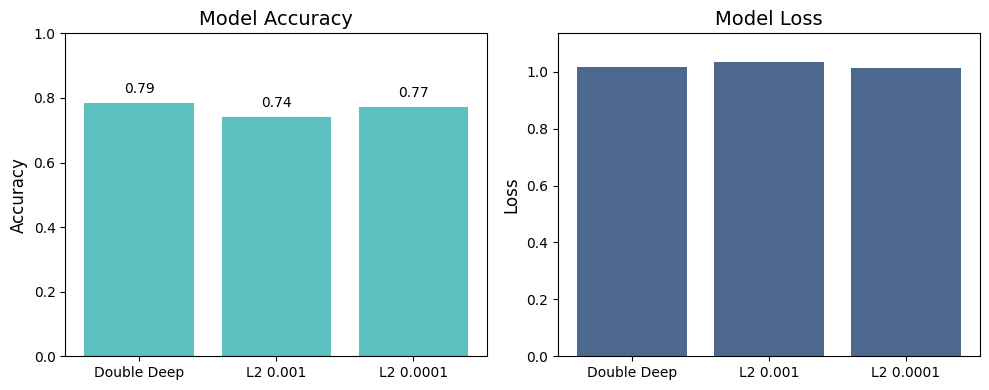

In [ ]:
best = get_best_epoch_stats( ('Double Deep', 'L2 0.001', 'L2 0.0001'), (history_doubleDeep, history_l2_001, history_l2_0001)  )
plot_model_metrics(*best)

### Optional Utilities
Saving the models

In [ ]:
model_doubleDeep_RMSprop.save('models/model_doubleDeep_RMSprop.keras')
model_l2_001.save('models/model_l2_001.keras')
model_l2_0001.save('models/model_l2_0001.keras')

# Save history
with open('history/model_doubleDeep_RMSprop.pkl', 'wb') as file:
    pickle.dump(history_doubleDeep_RMSprop.history, file)

with open('history/model_l2_001.pkl', 'wb') as file:
    pickle.dump(history_l2_001.history, file)

with open('history/model_l2_0001.pkl', 'wb') as file:
    pickle.dump(history_l2_0001.history, file)

### Conclusion

In this part, we saw that ...

* Altering the optimizer to RMSprop did not improve model performance. Our initial model, which was using Adam, had the same accuracy, but with a slightly lower loss.
* L2 regularization did not lead to any improvement either. The combination of a lot of data, a dropout layer and a l2 regularization seem to have resulted in over-regularization and a model that struggled to fit the training data. This is the case even though we added a small about of l2 regularization.
* Therefore, we keep our best model, which is the Double Deep.

### Comparison with AlexNet and Inception-ResNet-v2

In this last part of the project, I will compare our best performing model - the Double Deep - with two of the models used in the paper by Llamas et al. (2017) - Alex net and Inception-Res-v2. Alex net is a model that among others utilize stacked convolutional layers, ReLU activations and dropout for regularization. It achieved a remarkable performance on the ImageNet dataset in 2012. In our case, and also more commonly, Alex net is not pre-trained. Inception-ResNet-v2, on the other hand, is a model that is pre-trained on imagenet data, which consists of 1000 object classes and contains 1,281,167 training images. In addition, it uses parallel convolutional layers of different sizes to capture diverse features, with the residual connections from ResNet that allow for deeper networks by facilitating gradient flow. 

References:
Llamas J, M. Lerones P, Medina R, Zalama E, Gómez-García-Bermejo J. Classification of Architectural Heritage Images Using Deep Learning Techniques. Applied Sciences. 2017; 7(10):992. https://doi.org/10.3390/app7100992

### AlexNet

In [ ]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

# Adapted AlexNet architecture for 128x128 input images and 10 output classes
model_alexnet_adapted = Sequential([
    # First convolutional layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(128, 128, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Second convolutional layer
    Conv2D(filters=256, kernel_size=(5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Third convolutional layer
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fourth convolutional layer
    Conv2D(filters=384, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    # Fifth convolutional layer
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    
    # Flatten the network before fully connected layers
    Flatten(),
    
    # First fully connected layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Second fully connected layer
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output layer with 10 units for the 10 classes
    Dense(10, activation='softmax')
])

# Compile the model
model_alexnet_adapted.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
#model_alexnet_adapted.summary()

# Train the model
history_alexnet_adapted = model_alexnet_adapted.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 177s 671ms/step - accuracy: 0.2486 - loss: 4.3466 - val_accuracy: 0.1960 - val_loss: 2.0166
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 168s 658ms/step - accuracy: 0.3267 - loss: 1.8778 - val_accuracy: 0.1117 - val_loss: 20.2905
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 169s 661ms/step - accuracy: 0.4699 - loss: 1.5936 - val_accuracy: 0.3257 - val_loss: 2.5418
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 170s 664ms/step - accuracy: 0.5623 - loss: 1.3567 - val_accuracy: 0.4188 - val_loss: 2.2739
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 170s 664ms/step - accuracy: 0.6244 - loss: 1.1787 - val_accuracy: 0.5685 - val_loss: 1.3278
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 177s 689ms/step - accuracy: 0.6644 - loss: 1.0430 - val_accuracy: 0.5241 - val_loss: 1.5686
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 182s 711ms/step - accuracy: 0.6977 - loss: 0.9543 - val_accuracy: 0.5636 - val_lo

### Inception-ResNet-v2

In [ ]:
# Create train and validation generator
train_generator = create_train_generator('data/train', target_size=(128, 128), batch_size=32)
val_generator = create_val_generator('data/val', target_size=(128, 128), batch_size=32)

# early_stopper
early_stopper = create_early_stopper(monitor='val_accuracy', patience=5)

def create_inception_resnet_v2(input_shape=(128, 128, 3), num_classes=10):
    # Load Inception-ResNet-v2 with pre-trained ImageNet weights, excluding the top layer
    import ssl
    ssl._create_default_https_context = ssl._create_unverified_context  # Disable SSL verification temporarily
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

    # Freeze the layers of the base model to prevent them from being updated during training
    for layer in base_model.layers:
        layer.trainable = False

    # Add new classifier layers
    x = GlobalAveragePooling2D()(base_model.output)  # Add a global spatial average pooling layer
    x = Dense(1024, activation='relu')(x)            # Add a fully-connected layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Add a softmax layer for 10 classes

    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the Inception-ResNet-v2 model
model_inception_resnet_v2 = create_inception_resnet_v2()

# Model summary
#model_inception_resnet_v2.summary()

# Train the model
history_inception_resnet_v2 = model_inception_resnet_v2.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopper]
)

Found 8183 images belonging to 10 classes.
Found 2051 images belonging to 10 classes.
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 224s 796ms/step - accuracy: 0.7208 - loss: 2.0358 - val_accuracy: 0.8942 - val_loss: 0.3204
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 192s 751ms/step - accuracy: 0.9026 - loss: 0.3043 - val_accuracy: 0.8830 - val_loss: 0.3618
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 191s 745ms/step - accuracy: 0.9065 - loss: 0.2866 - val_accuracy: 0.8918 - val_loss: 0.3642
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 194s 756ms/step - accuracy: 0.9352 - loss: 0.2000 - val_accuracy: 0.8961 - val_loss: 0.3103
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 192s 750ms/step - accuracy: 0.9393 - loss: 0.1803 - val_accuracy: 0.9113 - val_loss: 0.2867
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 191s 746ms/step - accuracy: 0.9399 - loss: 0.1660 - val_accuracy: 0.9244 - val_loss: 0.2400
Epoch 7/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 192s 750ms/step - accuracy: 0

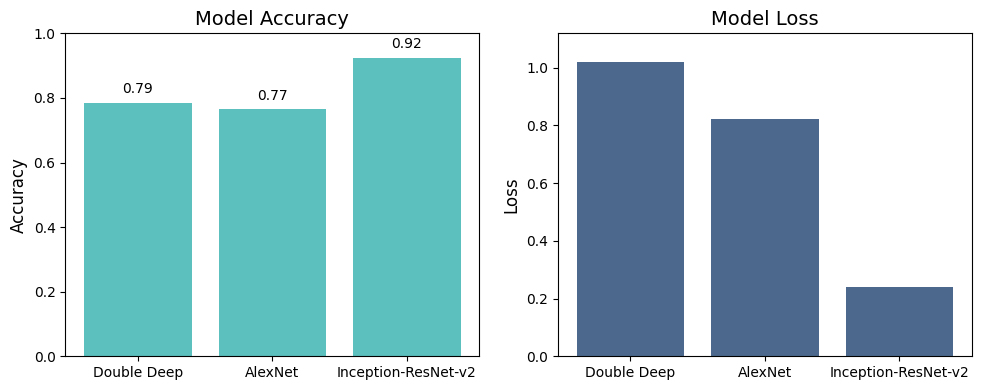

In [ ]:
best = get_best_epoch_stats( ('Double Deep', 'AlexNet', 'Inception-ResNet-v2'), (history_doubleDeep, history_alexnet_adapted, history_inception_resnet_v2)  )
plot_model_metrics(*best)

### Utilities
Saving the models

In [ ]:
# Ensure the 'models' directory exists
os.makedirs('models', exist_ok=True)

model_alexnet_adapted.save('models/model_alexnet_adapted.keras')
model_inception_resnet_v2.save('models/model_inception_resnet_v2.keras')

# Ensure the 'history' directory exists
os.makedirs('history', exist_ok=True)

# Save history
with open('history/model_alexnet_adapted.pkl', 'wb') as file:
    pickle.dump(history_alexnet_adapted.history, file)

with open('history/model_inception_resnet_v2.pkl', 'wb') as file:
    pickle.dump(history_inception_resnet_v2.history, file)

### Final Conclusion

In this assignment, I demonstrated that it is feasible to build a CNN model capable of accurately classifying architectural heritage elements. Our best-performing model achieved an accuracy of approximately 80%, which is quite impressive given the task of classifying elements into 10 distinct categories. In comparison, random classification would yield a statistical accuracy of just 10%.

Our findings revealed the following insights:

* Model architecture plays a more crucial role in performance than traditional hyperparameter tuning and regularization.
* Incorporating both depth and double convolution layers positively impacts performance, and their combination yields particularly strong results.
* Experimenting with various architecture and hyperparameter combinations in CNNs is challenging due to lengthy training times.
* Pre-trained models, such as InceptionResNet v2, generally perform better than models trained from scratch. In our case, the InceptionResNet model achieved a classification accuracy of 92%, significantly surpassing the AlexNet model, which our custom model also outperformed.
